In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from glob import glob
import tables as tb
import tqdm


import multiprocessing as mp

In [3]:
import sys
sys.path.insert(0, 'code')
from models import *
from v13_deeplab import *

In [4]:
MODEL_NAME = 'v13'
ORIGINAL_SIZE = 650
sz = 256
num_slice = 9
STRIDE_SZ = 197
PATH = 'data/'

num_gpus = 2
gpu_start = 4
num_workers = int(3.7 * num_gpus)
device_ids = range(gpu_start, gpu_start + num_gpus)
torch.cuda.set_device(gpu_start)

bs = 32 * num_gpus 
BASE_DIR = "data/train"
BASE_TEST_DIR = "data/test"
WORKING_DIR = "data/working"

# Restore later
IMAGE_DIR = "data/working/images/{}".format('v12')
# IMAGE_DIR = "data/working/images/{}".format('v5')
V5_IMAGE_DIR = "data/working/images/{}".format('v5')

# ---------------------------------------------------------
# Parameters
MIN_POLYGON_AREA = 30  # 30

# ---------------------------------------------------------
# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# ---------------------------------------------------------
# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut.csv"

# ---------------------------------------------------------
# Image list, Image container and mask container
FMT_VALTRAIN_IM_FOLDER = V5_IMAGE_DIR + "/trn_full_rgb/"
FMT_VALTEST_IM_FOLDER = V5_IMAGE_DIR + "/test_full_rgb/"

FMT_VALTRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
# FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
# FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
FMT_VALTRAIN_MASK_STORE = V5_IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTEST_MASK_STORE = V5_IMAGE_DIR + "/valtest_{}_mask.h5"
# FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"
# FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"
FMT_VALTRAIN_MUL_STORE = V5_IMAGE_DIR + "/valtrain_{}_mul.h5"
FMT_VALTEST_MUL_STORE = V5_IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_TRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_train_ImageId.csv"
FMT_TEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TRAIN_IM_STORE = IMAGE_DIR + "/train_{}_im.h5"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TRAIN_MASK_STORE = IMAGE_DIR + "/train_{}_mask.h5"
FMT_TRAIN_MUL_STORE = IMAGE_DIR + "/train_{}_mul.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"
FMT_IMMEAN = V5_IMAGE_DIR + "/{}_immean.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

# ---------------------------------------------------------
# Model files
MODEL_DIR = "data/working/models/{}".format(MODEL_NAME)
FMT_VALMODEL_PATH = MODEL_DIR + "/{}_val_weights.h5"
FMT_FULLMODEL_PATH = MODEL_DIR + "/{}_full_weights.h5"
FMT_VALMODEL_HIST = MODEL_DIR + "/{}_val_hist.csv"
FMT_VALMODEL_EVALHIST = MODEL_DIR + "/{}_val_evalhist.csv"
FMT_VALMODEL_EVALTHHIST = MODEL_DIR + "/{}_val_evalhist_th.csv"

# ---------------------------------------------------------
# Prediction & polygon result
FMT_TESTPRED_PATH = MODEL_DIR + "/{}_pred.h5"
FMT_VALTESTPRED_PATH = MODEL_DIR + "/{}_eval_pred.h5"
FMT_VALTESTPOLY_PATH = MODEL_DIR + "/{}_eval_poly.csv"
FMT_VALTESTTRUTH_PATH = MODEL_DIR + "/{}_eval_poly_truth.csv"
FMT_VALTESTPOLY_OVALL_PATH = MODEL_DIR + "/eval_poly.csv"
FMT_VALTESTTRUTH_OVALL_PATH = MODEL_DIR + "/eval_poly_truth.csv"
FMT_TESTPOLY_PATH = MODEL_DIR + "/{}_poly.csv"
FN_SOLUTION_CSV = "data/output/{}.csv".format(MODEL_NAME)

# ---------------------------------------------------------
# Model related files (others)
FMT_VALMODEL_LAST_PATH = MODEL_DIR + "/{}_val_weights_last.h5"
FMT_FULLMODEL_LAST_PATH = MODEL_DIR + "/{}_full_weights_last.h5"

datapaths = ['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']

## Preprocessing

In [5]:
# datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
# !python code/v5_im-full_rgb.py preproc_train {datapaths[1]}

In [6]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[3]}

In [7]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[0]}
# !python code/v5_im-full_rgb.py preproc_train {datapaths[2]}

In [8]:
# for d in datapaths: print(d, end=' ')

In [9]:
# !parallel python code/v5_im-full_rgb.py preproc_train {} ::: data/train/AOI_2_Vegas_Train data/train/AOI_3_Paris_Train data/train/AOI_4_Shanghai_Train data/train/AOI_5_Khartoum_Train

In [10]:
# for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
#     !python code/v12_im_deeplab.py preproc_train {train_path}

### Overload

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from concurrent.futures import ThreadPoolExecutor

In [12]:
def get_data(area_id, is_test, max_workers=3):
    prefix = area_id_to_prefix(area_id)
    fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix) if is_test else FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
    df_train = pd.read_csv(fn_train)
    
    fn_im = FMT_VALTEST_MASK_STORE.format(prefix) if is_test else FMT_VALTRAIN_MASK_STORE.format(prefix)
    y_val = np.empty((df_train.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 1))
    with tb.open_file(fn_im, 'r') as f:                                         
        for i, image_id in tqdm.tqdm_notebook(enumerate(df_train.ImageId.tolist()), total=df_train.shape[0], desc='ims'):
            fn = '/' + image_id
            y_val[i] = np.array(f.get_node(fn))[..., None]
            
    fn_im = FMT_VALTEST_IM_FOLDER if is_test else FMT_VALTRAIN_IM_FOLDER
    X_val = np.empty((df_train.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3))
    if max_workers == 1:
        for i, image_id in tqdm.tqdm_notebook(enumerate(df_train.ImageId.tolist()), total=df_train.shape[0], desc='ims'):
            X_val[i] = plt.imread(fn_im + image_id + '.png')[...,:3]
    else:
        with ThreadPoolExecutor(max_workers=max_workers) as e:
            gen = e.map(plt.imread, [fn_im + image_id + '.png' for image_id in df_train.ImageId.tolist()])
            for i, im in enumerate(gen):
                X_val[i] = im[...,:3]
#         im = np.moveaxis(im, -1, 0)

    X_val, y_val = X_val.astype('float'), y_val.astype('float')
    return X_val, y_val

In [13]:
# for i in range(1, 8):
#     %time res = get_data(2, False, i, 100)

max_workers = 3

In [14]:
# memory dataset
def get_dataset(datapath):
    area_id = directory_name_to_area_id(datapath)
    prefix = area_id_to_prefix(area_id)
    trn_x, trn_y = get_data(area_id, False)
#     print(trn_x.shape, trn_y.shape)
#     trn_x = np.moveaxis(trn_x, 1, -1).astype('float') # --> [bs, h, w, ch]
#     trn_y = np.moveaxis(trn_y, 1, -1).astype('float')

#     print(trn_x.shape, trn_y.shape)
    trn_y = np.broadcast_to(trn_y, [trn_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])

    val_x, val_y = get_data(area_id, True)
#     val_x = val_x[:,:3]
#     val_x = np.moveaxis(val_x, 1, -1).astype('float')
#     val_y = val_y[:,:3]
#     val_y = np.moveaxis(val_y, 1, -1).astype('float')
    val_y = np.broadcast_to(val_y, [val_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])
               
    return (trn_x,trn_y), (val_x,val_y)


In [15]:
class ArraysSingleDataset(BaseDataset):
    def __init__(self, is_trn, y, transform):
        # input: ch x w x h
        global trn_x, trn_y, val_x, val_y
        self.is_trn = is_trn
        self.sz = trn_x[0].shape[1] if self.is_trn else val_x[0].shape[1]
        super().__init__(transform)

        
    def get_im(self, i, is_y):
        if is_y:
            im = trn_y[i//num_slice] if self.is_trn else val_y[i//num_slice]
        else:
            im = trn_x[i//num_slice] if self.is_trn else val_x[i//num_slice]
        slice_pos = i % num_slice
        a = np.sqrt(num_slice)
        cut_i = slice_pos // a
        cut_j = slice_pos % a
        stride = (self.sz - sz) // a
        cut_x = int(cut_j * stride)
        cut_y = int(cut_i * stride)
        return im[cut_x:cut_x + sz, cut_y:cut_y + sz]
    
    def get_x(self, i): return self.get_im(i, False)
    def get_y(self, i): return self.get_im(i, True)
    def get_n(self): return trn_x.shape[0] * num_slice if self.is_trn else val_x.shape[0] * num_slice
    def get_sz(self): return self.sz
    def get_c(self): return 1
    def denorm(self, arr):
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
#         return np.clip(self.transform.denorm(np.rollaxis(arr,1,4)), 0, 1)
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [16]:
cut_base = 8
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        c = list(children(self.model.module))
        return [c[:cut_base],
               c[cut_base:]]

In [17]:
def sep_iou(y_pred, y_true, thresh=0.5):
    return np.array([jaccard_coef(p, t) for (p, t) in zip(y_pred, y_true)])
    
## cuda version
def jaccard_coef_cuda(y_pred, y_true, thresh=0.5):
    smooth = T(1e-12)
    y_pred = (y_pred > thresh).float()
    y_true = (y_true > thresh).float()
    intersection = y_true * y_pred
    sum_ = torch.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return torch.mean(jac)

## np version
def jaccard_coef(y_pred, y_true=None, thresh=0.5):
    if isinstance(y_pred, tuple):
        y_pred, y_true = y_pred
    elif y_true is None:
        raise TypeError
        
    smooth = 1e-12
    y_pred = to_np(y_pred) > thresh
    y_true = to_np(y_true) > thresh
    intersection = y_true * y_pred
    sum_ = np.sum(y_true) + np.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

from concurrent.futures import ThreadPoolExecutor
def jaccard_coef_parallel(y_pred, y_true, thresh=0.5, num_workers=8):
    if num_workers == 0:
        return jaccard_coef(y_pred, y_true, thresh=0.5)
    with ThreadPoolExecutor(max_workers=num_workers) as e:
        jac = list(e.map(jaccard_coef, zip(y_pred, y_true)))
        return np.mean(jac)

In [18]:
# t1 = np.zeros((2000,256,256))
# t2 = np.ones((2000,256,256))

In [19]:
# %time jaccard_coef(t1, t2)

In [20]:
# for i in range(1, 24, 2):
#     %time jaccard_coef_parallel(t1, t2, num_workers=i)

num_workers = 8

In [21]:
def get_rgb_mean_stat(area_id):
    prefix = area_id_to_prefix(area_id)

    with tb.open_file(FMT_IMMEAN.format(prefix), 'r') as f:
        im_mean = np.array(f.get_node('/immean'))[:3]
    
    mean = [np.mean(im_mean[i]) for i in range(3)]
    std = [np.std(im_mean[i]) for i in range(3)]
    return np.stack([np.array(mean), np.array(std)])

def get_md_model(datapaths, device_ids=device_ids):
#     (trn_x, trn_y), (val_x, val_y) = trn, val
    aug_tfms = transforms_top_down
    for o in aug_tfms: o.tfm_y = TfmType.CLASS
        
    area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
    stats = np.mean([get_rgb_mean_stat(area_id) for area_id in area_ids], axis=0)
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    
    datasets = ImageData.get_ds(ArraysSingleDataset, (True, True), (False, False), tfms)
    md = ImageData('data', datasets, bs, num_workers=num_workers, classes=None)
    denorm = md.trn_ds.denorm

    if not Path(MODEL_DIR).exists():
        Path(MODEL_DIR).mkdir(parents=True)

    net = to_gpu(UNet16(pretrained='vgg'))
    net = nn.DataParallel(net, device_ids)
    models = UpsampleModel(net)
    return md, models, denorm

def expanded_loss(pred, target):
#     pred = torch.clamp(pred, 0, 1)
    return F.binary_cross_entropy_with_logits(pred[:,0], target)

In [22]:
(trn_x,trn_y), (val_x,val_y) = (None, None), (None, None)
last_datapath = None
crit=expanded_loss
metrics = jaccard_coef_parallel

def learner_on_dataset(datapath):
    global trn_x, trn_y, val_x, val_y
    global last_datapath
    
    last_datapath = datapath
    (trn_x,trn_y), (val_x,val_y) = get_dataset(datapath)
    md, model, denorm = get_md_model([datapath])
    print('Data finished loading:', datapath)
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=crit
    learn.metrics=[metrics]
    return learn, denorm

def load_backup_learn():
    global last_datapath
    
    md, model, denorm = get_md_model([last_datapath])
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=crit
    learn.metrics=[metrics]
    return learn, denorm

In [23]:
def plot_lr_loss(learn, save_name=None):
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.tight_layout()
    ax[0].plot(learn.sched.iterations, learn.sched.losses)
    ax[0].set_xlabel('loss')
    ax[1].plot(learn.sched.iterations, learn.sched.lrs)
    ax[1].set_xlabel('lr')
    if save_name is not None:
        save_path = Path('data/figs')
        if not save_path.exists(): save_path.mkdir(parent=True)
        fig.savefig(str(save_path / Path(save_name)) + '.png')

def train_and_plot(idx, fn, lrs, n_cycles, wds=[0.025/3, 0.025], use_wd_sched=False, **kwargs):
    learn.fit(lrs, n_cycles, wds=wds, **kwargs)
    save_name = fn + '_' + str(idx)
    learn.save(save_name)
    plot_lr_loss(learn, save_name)
    
def bool_pred(pred, thresh=0.5):
    return to_np(pred > thresh)

In [24]:
def plot_worse_cross_entropy(tta, shift=0, n_ims=9, is_best=False, step=2):
    pass

def plot_worse_iou(tta, shift=0, n_ims=9, is_best=False, step=2):
    tta_exp = np.mean(np.exp(tta[0]), axis=0).squeeze()
    ious = sep_iou(tta_exp, tta[1])
    lowest_iou_idx = np.argsort(ious)
    if is_best:
        lowest_iou_idx = np.flip(lowest_iou_idx, 0)
    
    col = 4
    plt.subplots(n_ims, 4, figsize=(16, 4 * n_ims))
    for i in range(n_ims):
        idx = i * step + shift
        x, _ = learn.data.val_dl.get_batch([lowest_iou_idx[idx]])
        plt.subplot(n_ims, col, i * col + 1)
        plt.xlabel('rgb')
        plt.imshow(denorm(x)[0])

        plt.subplot(n_ims, col, i * col + 2)
        plt.imshow(tta_exp[lowest_iou_idx[idx]])
        plt.xlabel('Prediction: iou = ' + str(ious[lowest_iou_idx[idx]]))
        
        plt.subplot(n_ims, col, i * col + 3)
        plt.imshow(bool_pred(tta_exp[lowest_iou_idx[idx]], 0.5))
        plt.xlabel('bool_pred, arg ' + str(idx))

        plt.subplot(n_ims, col, i * col + 4)
        plt.imshow(tta[1][lowest_iou_idx[idx]])
        plt.xlabel('GT')
    plt.tight_layout()

In [25]:
learn, denorm = None, None

In [ ]:
# sequential: if True, in one outer loop, every dataset is trained only once
def train_on_full_dataset(epochs, lrs, wds, sequential=False, save_starter='full_dataset_beginner',\
                          cycle_len=2, cycle_mult=2, save_path=Path('data/figs'), datapath_slice=0,\
                         epoch_shift=0, use_wd_sched=False, **kwargs):
    global learn, denorm
        
    for out_epoch in tqdm.tnrange(epochs if sequential else 1, desc='out'):
        datapath_slice = 0 if sequential else datapath_slice
        for i, datapath in tqdm.tqdm_notebook(enumerate(datapaths[datapath_slice:]),\
                                              total=len(datapaths), desc='datapaths'):
            i += epoch_shift
            if last_datapath == datapath:
                learn, denorm = load_backup_learn()
            else:
                learn, denorm = learner_on_dataset(datapath)
            
            best_save_name = 'full_dataset_out' if sequential else 'full_dataset_in'
            epoch_save_name_base = 'full_dataset'
            epoch_save_name_base += '_out_' if sequential else '_in_'
            
            if out_epoch:
                learn.load(epoch_save_name_base + str(out_epoch - 1))
            elif save_starter != '':
                learn.load(save_starter)
            
            learn.unfreeze();
            in_epochs = epochs if not sequential else 1
            %time learn.fit(lrs, in_epochs, wds=wds, use_wd_sched=use_wd_sched, cycle_len=cycle_len,\
                            cycle_mult=cycle_mult, use_clr=None, best_save_name=best_save_name, **kwargs)

            learn.save(epoch_save_name_base + str(out_epoch))
            
            save_name = epoch_save_name_base + str(out_epoch) + '_' + str(i)
            plot_lr_loss(learn, Path(save_name))

HBox(children=(IntProgress(value=0, description='out', max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

Exception in thread Thread-1717:
Traceback (most recent call last):
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.152119   0.106968   0.525283  
    1      0.152365   0.103769   0.517554                    
CPU times: user 1h 10min 31s, sys: 12min 49s, total: 1h 23min 21s
Wall time: 5min 17s


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.199572   0.155416   0.050082  
    1      0.191535   0.151489   0.054503                    
CPU times: user 4h 8min 21s, sys: 44min 34s, total: 4h 52min 56s
Wall time: 17min 40s


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.210674   0.163217   0.351436  
    1      0.197051   0.152723   0.336972                    
CPU times: user 5h 4min 22s, sys: 54min 58s, total: 5h 59min 21s
Wall time: 20min 39s


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.2419     0.181867   0.258044  
    1      0.228576   0.178905   0.262065                    
CPU times: user 1h 4min 47s, sys: 11min 50s, total: 1h 16min 37s
Wall time: 4min 29s


HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))

Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.154955   0.099442   0.5372    
    1      0.149945   0.09827    0.536878                    
CPU times: user 1h 17min 25s, sys: 13min 35s, total: 1h 31min 1s
Wall time: 5min 21s


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.195827   0.156078   0.071612  
    1      0.18967    0.147418   0.06796                     
CPU times: user 4h 22min 31s, sys: 47min 53s, total: 5h 10min 24s
Wall time: 18min 7s


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.19358    0.160166   0.321942  
    1      0.189206   0.14624    0.360568                    
CPU times: user 5h 3min 35s, sys: 56min 43s, total: 6h 18s
Wall time: 21min 16s


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.225894   0.176435   0.260603  
    1      0.219736   0.174282   0.262796                   
CPU times: user 1h 6min 42s, sys: 12min 5s, total: 1h 18min 47s
Wall time: 4min 41s


HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))

Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.158169   0.106261   0.526894  
    1      0.15218    0.099989   0.540743                    
CPU times: user 1h 14min 24s, sys: 13min 30s, total: 1h 27min 54s
Wall time: 5min 21s


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.198533   0.155947   0.085357  
    1      0.190049   0.147747   0.075553                    
CPU times: user 4h 14min 36s, sys: 46min 20s, total: 5h 56s
Wall time: 17min 32s


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.202531   0.162176   0.387396  
    1      0.187865   0.147191   0.360487                    
CPU times: user 5h 5min 31s, sys: 55min 8s, total: 6h 40s
Wall time: 20min 29s


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.223014   0.175246   0.267547  
    1      0.217157   0.172013   0.263527                    
CPU times: user 1h 4min 51s, sys: 11min 43s, total: 1h 16min 35s
Wall time: 4min 20s


HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))

Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.158078   0.10342    0.531403  
    1      0.150176   0.099378   0.539454                    
CPU times: user 1h 15min 5s, sys: 13min 33s, total: 1h 28min 38s
Wall time: 5min 12s


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.199256   0.152118   0.073919  
    1      0.190465   0.147583   0.07613                     
CPU times: user 4h 11min 1s, sys: 45min 46s, total: 4h 56min 48s
Wall time: 17min 22s


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.195908   0.152495   0.355315  
    1      0.191331   0.14796    0.36178                     
CPU times: user 5h 14min 49s, sys: 56min 5s, total: 6h 10min 54s
Wall time: 21min 8s


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.223395   0.172726   0.259141  
 52%|█████▏    | 52/100 [00:56<00:51,  1.08s/it, loss=0.219]Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.158604   0.102516   0.550404  
    1      0.151544   0.100582   0.542997                    
CPU times: user 1h 17min 16s, sys: 13min 15s, total: 1h 30min 32s
Wall time: 5min 17s


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.196325   0.155157   0.067191  
    1      0.188592   0.147472   0.078629                    
CPU times: user 4h 26min 48s, sys: 47min 43s, total: 5h 14min 32s
Wall time: 17min 48s


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.220857   0.169122   0.263527  
    1      0.21517    0.168607   0.263527                    
CPU times: user 1h 6min 45s, sys: 11min 22s, total: 1h 18min 8s
Wall time: 4min 39s


HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))

Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.161626   0.103809   0.535268  
    1      0.152811   0.100241   0.543641                    
CPU times: user 1h 13min 40s, sys: 12min 51s, total: 1h 26min 32s
Wall time: 4min 55s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.20107    0.159779   0.067383  
    1      0.189686   0.149189   0.076514                    
CPU times: user 4h 18min 27s, sys: 45min 32s, total: 5h 4min
Wall time: 17min 1s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.20058    0.157212   0.3798    
    1      0.190482   0.148051   0.365497                    
CPU times: user 5h 7min 28s, sys: 54min 58s, total: 6h 2min 26s
Wall time: 20min 29s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.221847   0.17221    0.260603  
    1      0.214738   0.169342   0.266451                    
CPU times: user 1h 6min 5s, sys: 11min 22s, total: 1h 17min 27s
Wall time: 4min 28s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))

Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.16095    0.107217   0.529471  
    1      0.151914   0.101155   0.542675                    
CPU times: user 1h 11min 26s, sys: 13min 3s, total: 1h 24min 30s
Wall time: 5min 3s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.201338   0.155725   0.086991  
    1      0.192135   0.148759   0.074207                    
CPU times: user 3h 57min 50s, sys: 41min 47s, total: 4h 39min 37s
Wall time: 15min 25s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.196523   0.155563   0.353134  
    1      0.191547   0.148451   0.371477                    
CPU times: user 4h 56min 58s, sys: 53min 44s, total: 5h 50min 42s
Wall time: 18min 39s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.213581   0.167178   0.26572   
    1      0.213411   0.167072   0.264989                    
CPU times: user 1h 3min 20s, sys: 11min 25s, total: 1h 14min 45s
Wall time: 4min 10s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))

Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.155619   0.102648   0.544929  
    1      0.152366   0.101389   0.542997                    
CPU times: user 1h 12min 55s, sys: 12min 52s, total: 1h 25min 48s
Wall time: 4min 45s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.202182   0.157545   0.093911  
    1      0.190572   0.149131   0.07786                     
CPU times: user 4h 4min 37s, sys: 42min 54s, total: 4h 47min 32s
Wall time: 15min 53s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.200223   0.161125   0.394749  
    1      0.194192   0.149923   0.367598                    
CPU times: user 4h 55min 1s, sys: 52min 45s, total: 5h 47min 47s
Wall time: 18min 49s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.216938   0.167511   0.263527  
    1      0.216154   0.16596    0.267913                    
CPU times: user 1h 5min 24s, sys: 11min 42s, total: 1h 17min 6s
Wall time: 4min 4s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))

Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.159442   0.105113   0.527538  
    1      0.152467   0.100961   0.543641                    
CPU times: user 1h 13min 15s, sys: 13min 8s, total: 1h 26min 23s
Wall time: 4min 45s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.202595   0.158544   0.079398  
    1      0.195889   0.151159   0.081032                    
CPU times: user 4h 4min 26s, sys: 43min 31s, total: 4h 47min 57s
Wall time: 15min 54s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.204682   0.159478   0.343114  
    1      0.188809   0.149692   0.368164                    
CPU times: user 4h 56min 27s, sys: 54min 39s, total: 5h 51min 7s
Wall time: 19min 6s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.212749   0.169654   0.272664  
    1      0.211895   0.165918   0.266451                    
CPU times: user 1h 4min 56s, sys: 11min 19s, total: 1h 16min 16s
Wall time: 4min 27s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))

Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.159129   0.106764   0.552981  
    1      0.152742   0.102329   0.547506                    
CPU times: user 1h 11min 13s, sys: 12min 39s, total: 1h 23min 53s
Wall time: 4min 49s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.202323   0.160446   0.102658  
    1      0.194171   0.150906   0.082762                    
CPU times: user 4h 15min 51s, sys: 47min 47s, total: 5h 3min 38s
Wall time: 16min 20s


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

MemoryError: 

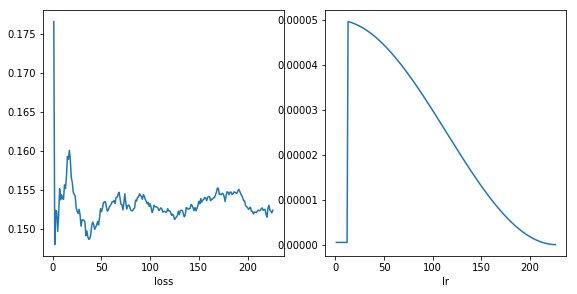

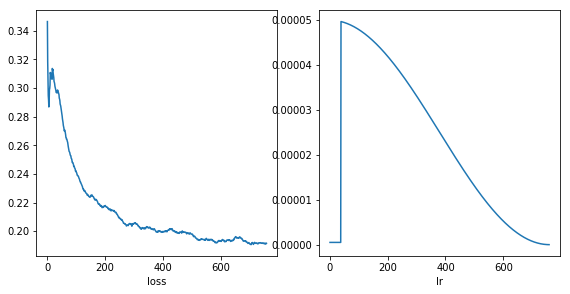

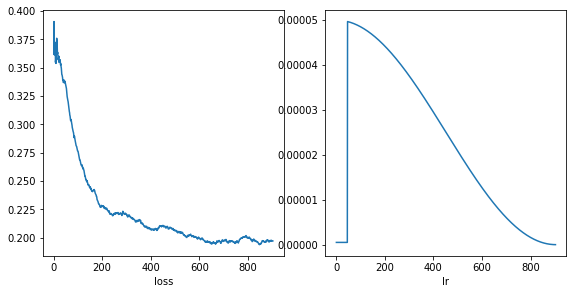

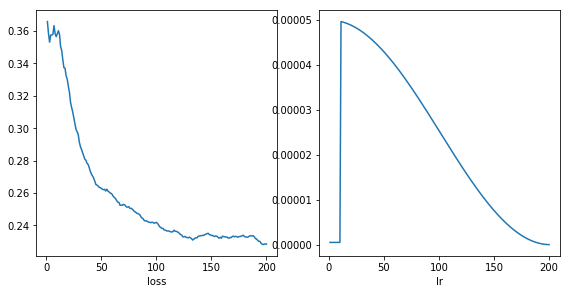

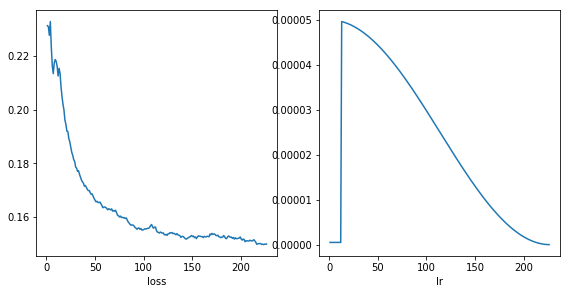

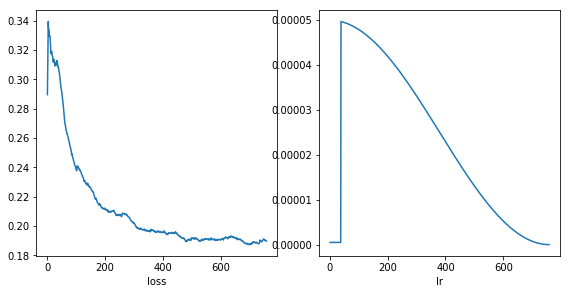

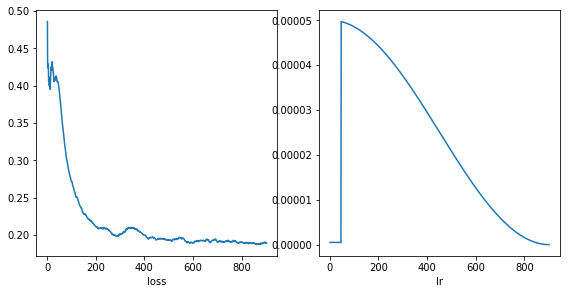

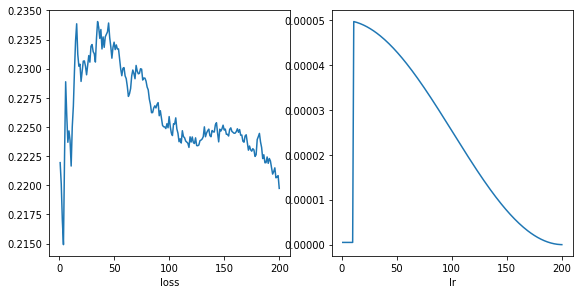

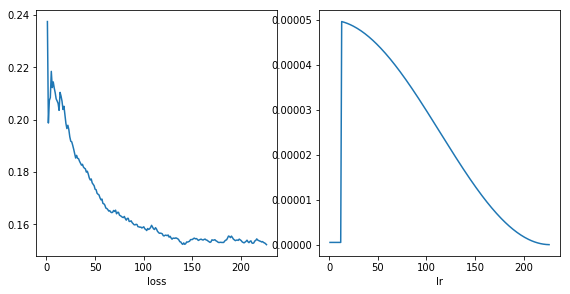

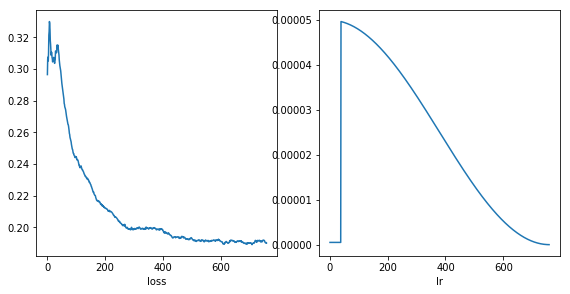

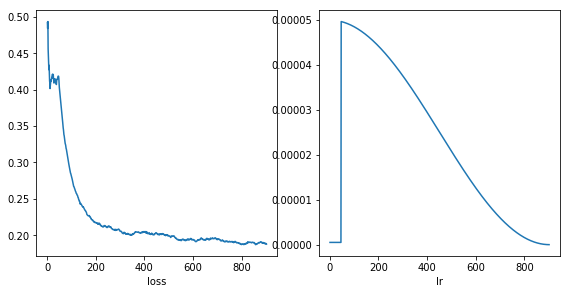

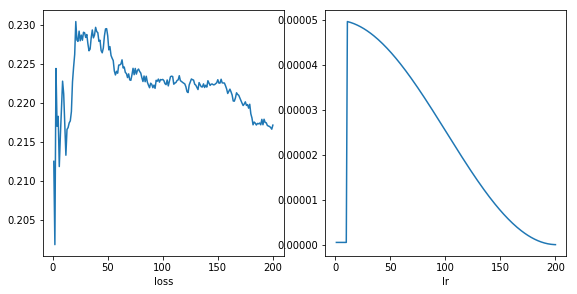

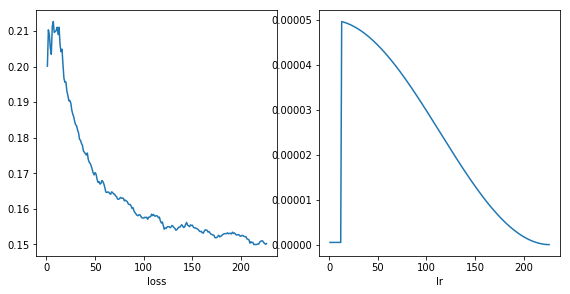

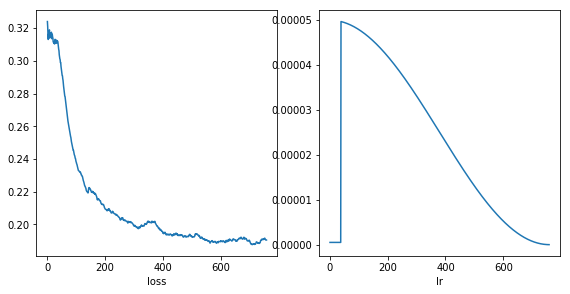

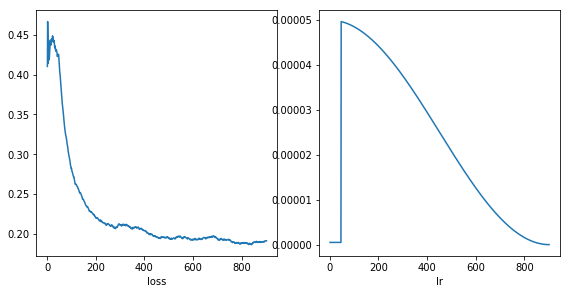

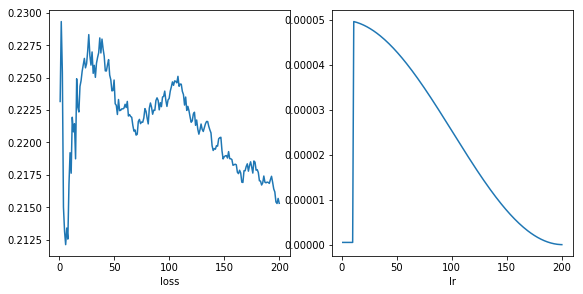

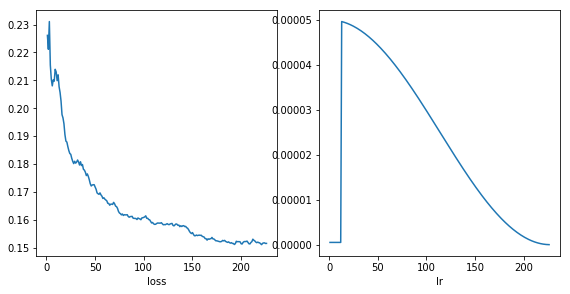

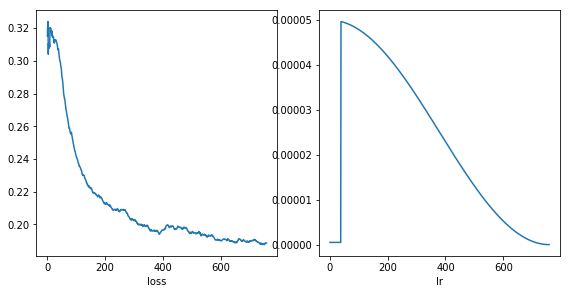

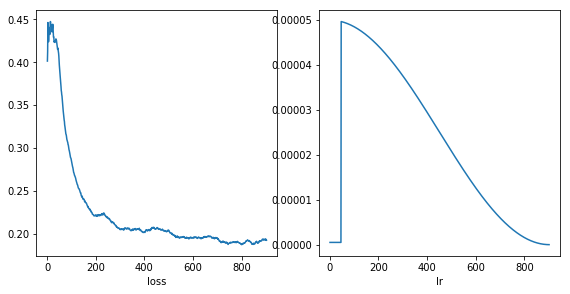

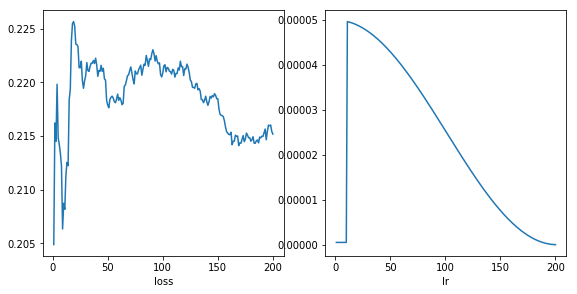

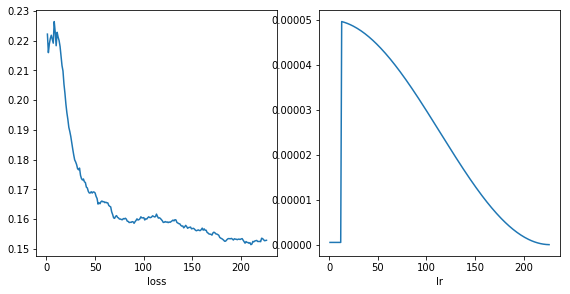

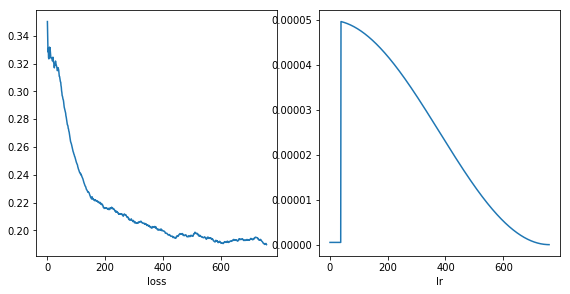

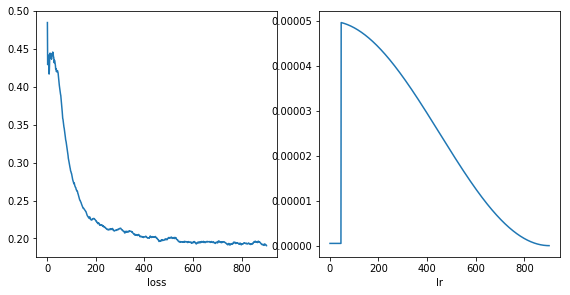

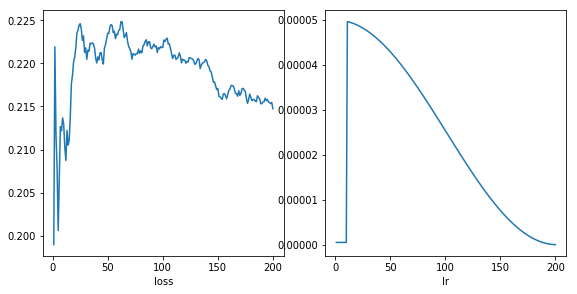

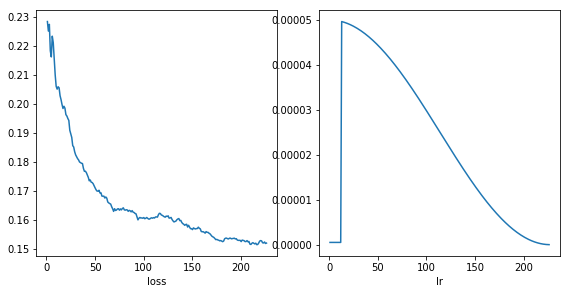

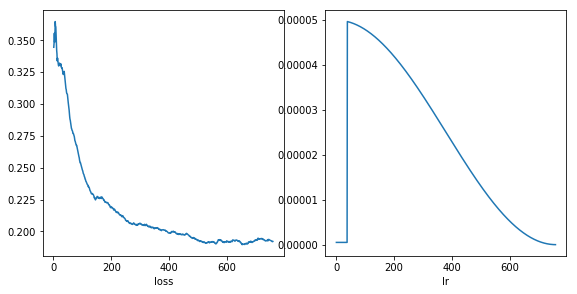

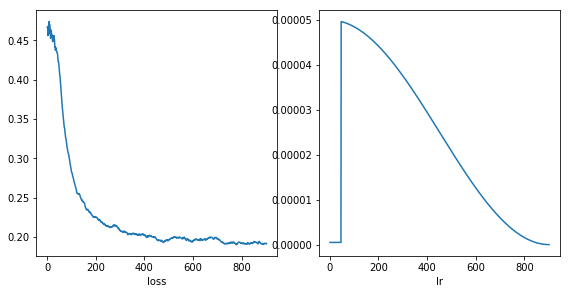

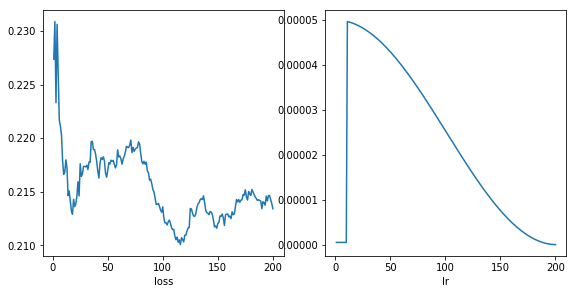

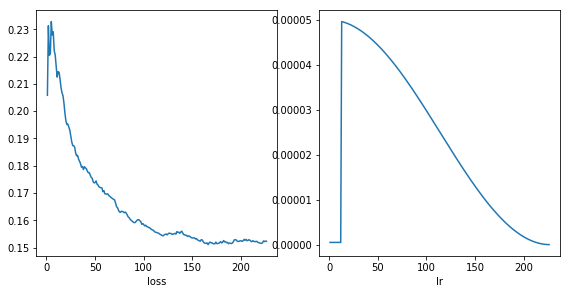

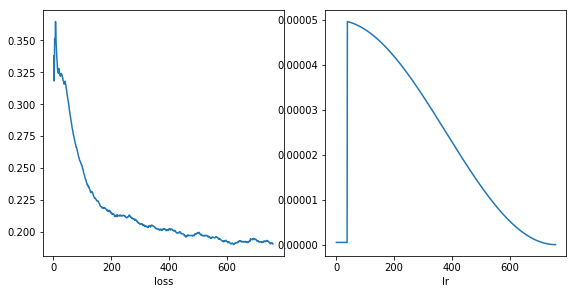

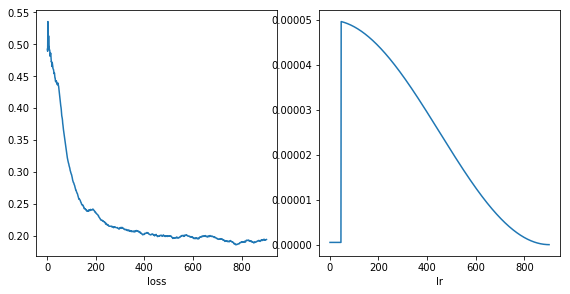

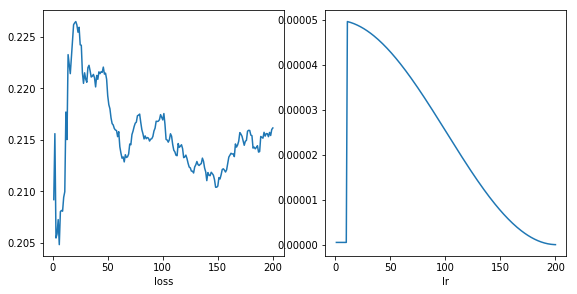

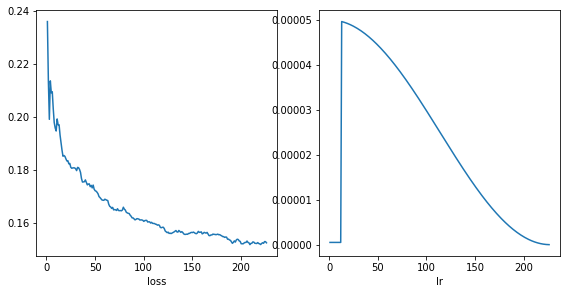

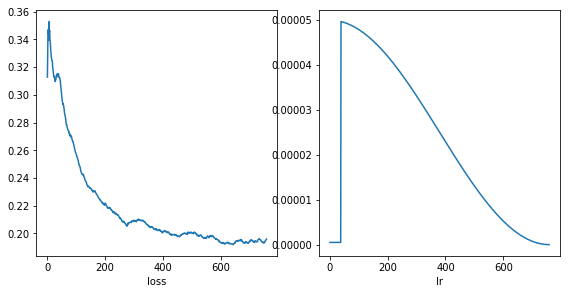

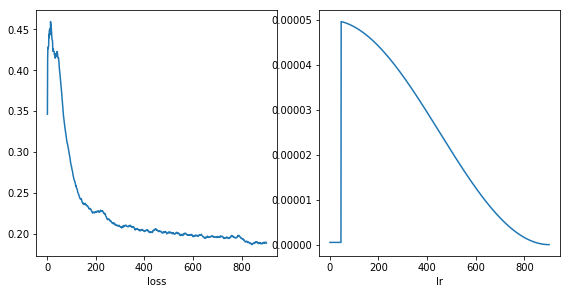

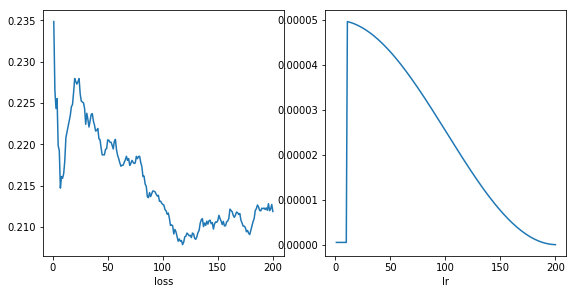

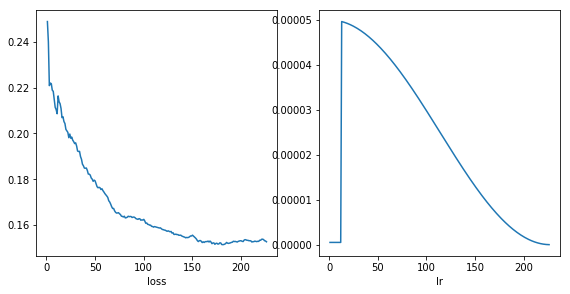

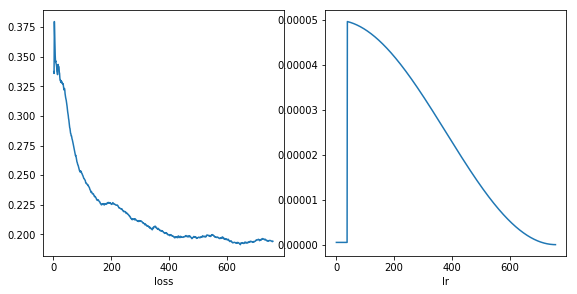

In [38]:
lr = 1e-4
lrs = np.array([lr/10, lr]) / 2
wd = 0.025
wds = [wd/3, wd]
train_on_full_dataset(14, lrs, wds, True, use_wd_sched=False, save_starter='full_dataset_out_0') # epoch 3 means actually 3x2=6 because cyc_len=2

Fine tune on vegas and validate

In [27]:
learn, denorm = learner_on_dataset(datapaths[0])

HBox(children=(IntProgress(value=0, description='ims', max=803), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=345), HTML(value='')))


Data finished loading: data/train/AOI_3_Paris_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.468324   0.623442   0.160035  
    1      0.67912    0.682738   0.160035                    
    2      0.69158    0.692712   0.160035                    
    3      0.681385   0.681374   0.160035                    
    4      0.685016   0.685761   0.160035                    
    5      0.689833   0.690604   0.160035                    
    6      0.692788   0.693049   0.160035                    
    7      0.681539   0.681111   0.160035                    
    8      0.682403   0.682335   0.160035                    
    9      0.684088   0.68422    0.160035                    
    10     0.686216   0.6865     0.160035                    
    11     0.688556   0.688897   0.160035                    
    12     0.690674   0.691      0.160035                    
    13     0.692274   0.692496   0.160035                    
    14     0.693058   0.693123   0.160035                    

CPU times: user 18h 39min

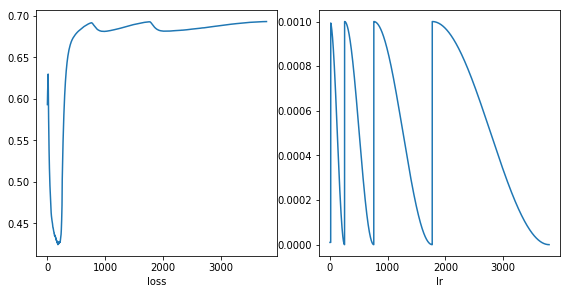

In [86]:
lr = 1e-3
lrs = np.array([lr/3, lr])
wd = 0.025
wds = [wd/10, wd]

learn.load('full_dataset_out_2')
learn.unfreeze()
%time train_and_plot(0, 'vegas_finetune', lrs, 4, wds=wds, use_wd_sched=True,\
                     cycle_len=1, cycle_mult=2, best_save_name='vegas_finetune')

lr too high? Overshooting.

In [ ]:
learn, denorm = load_backup_learn()

In [93]:
!ls data/models

autosaved.h5		    full_dataset_in.h5	   unfreezed_4.h5
autosaved_vegas.h5	    full_dataset_out_0.h5  unfreezed_5.h5
cycle_dataset_in_cyc_0.h5   full_dataset_out_1.h5  unfreezed_6.h5
cycle_dataset_in_cyc_1.h5   full_dataset_out_2.h5  unfreezed_7.h5
cycle_dataset_out_cyc_0.h5  full_dataset_out_3.h5  vegas_0.h5
freezed_1.h5		    full_dataset_out.h5    vegas_finetune_0.h5
full_dataset_beginner.h5    tmp.h5		   vegas_finetune.h5
full_dataset.h5		    unfreezed_2.h5	   vegas_scratch.h5
full_dataset_in_0.h5	    unfreezed_3.h5


In [32]:
learn.freeze_to(1)
learn.load('vegas_finetune_slow')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 58%|█████▊    | 66/113 [00:46<00:33,  1.42it/s, loss=136]  

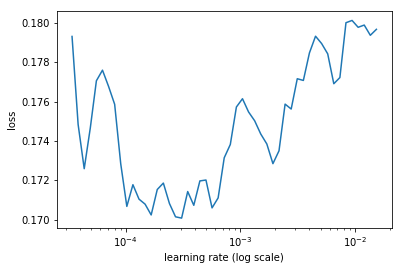

In [33]:
learn.lr_find()
learn.sched.plot()

### Training the best model for vegas

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from learn import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
num_gpus = 2
gpu_start = 8
num_workers = 3 * num_gpus
device_ids = range(gpu_start, gpu_start + num_gpus)
torch.cuda.set_device(gpu_start)
bs = 16 * num_gpus

In [6]:
learn, denorm, data = learner_on_dataset(datapaths[1], bs, device_ids, num_workers, model_name='unet',
                                         debug=False, global_dataset=False)
(trn_x,trn_y), (val_x,val_y) = data

HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))


Data finished loading: data/train/AOI_2_Vegas_Train


In [14]:
learn, denorm, data = learner_on_dataset(datapaths[1], bs, device_ids, num_workers, model_name='unet',
                                         debug=False, global_dataset=True, data=data)
(trn_x,trn_y), (val_x,val_y) = data

Data finished loading: data/train/AOI_2_Vegas_Train


In [4]:
learn.load('full_dataset_out')

learn.unfreeze()
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

  1%|          | 2/347 [00:07<20:07,  3.50s/it, loss=0.195] 


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.195483   0.145721   0.08374   
    1      0.186584   0.141497   0.100933                    
    2      0.191037   0.1514     0.149376                    
    3      0.186178   0.142106   0.148016                    
    4      0.182345   0.13652    0.131978                    
    5      0.182219   0.136543   0.128638                    

CPU times: user 7h 46min 1s, sys: 11h 30min 35s, total: 19h 16min 36s
Wall time: 1h 16min 2s


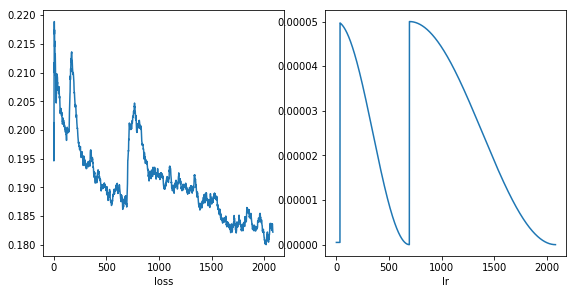

In [6]:
%%time
lr = 1e-4 / 2
lrs = np.array([lr/9, lr])
wd = 0.025
wds = [wd/3, wd]
learn.unfreeze()
train_and_plot(learn, 5, 'unet-vegas', lrs=lrs, n_cycles=2, wds=wds, use_wd_sched=False, cycle_len=2, cycle_mult=2,
               best_save_name='unet-vegas')

In [8]:
%%time
lr = 1e-4 / 2
lrs = np.array([lr/9, lr]) / 10
wd = 0.025
wds = [wd/3, wd]
learn.unfreeze()
train_and_plot(learn, 6, 'unet-vegas', lrs=lrs, n_cycles=3, wds=wds, use_wd_sched=False, cycle_len=2, cycle_mult=2,
               best_save_name='unet-vegas')

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.181575   0.135271   0.135152  
    1      0.181189   0.135007   0.135441                    
    2      0.18118    0.135506   0.129793                    
    3      0.179799   0.135079   0.133545                    
    4      0.180666   0.134528   0.135647                    
 90%|█████████ | 314/347 [06:20<00:40,  1.21s/it, loss=0.18] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    5      0.183302   0.134294   0.136348  
    7      0.182551   0.13561    0.136018                    
    8      0.181491   0.134102   0.136554                    
    9      0.179272   0.133484   0.139358                    
    10     0.17952    0.133471   0.138863                    
 33%|███▎      | 115/347 [02:18<04:39,  1.20s/it, loss=0.18] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Converged

In [7]:
learn.load('unet-vegas')

In [9]:
tta = learn.TTA()

In [10]:
tta_exp = np.mean(np.exp(tta[0]), axis=0).squeeze()

In [53]:
def plot_worse(tta, shift=0, n_ims=9, is_best=False):
    tta_exp = np.mean(np.exp(tta[0]), axis=0).squeeze()
    ious = sep_iou(tta_exp, tta[1])
    lowest_iou_idx = np.argsort(ious)
    if is_best:
        lowest_iou_idx = np.flip(lowest_iou_idx, 0)
    
    col = 4
    plt.subplots(n_ims, 4, figsize=(15,30))
    
    for i in range(n_ims):
        x, _ = learn.data.fix_dl.get_batch([lowest_iou_idx[i + shift]])
        plt.subplot(n_ims, col, i * col + 1)
        plt.xlabel('rgb')
        plt.imshow(denorm(x)[0])

        plt.subplot(n_ims, col, i * col + 2)
        plt.imshow(tta_exp[lowest_iou_idx[i + shift]])
        plt.xlabel('Prediction: iou = ' + str(ious[lowest_iou_idx[i + shift]]))
        
        plt.subplot(n_ims, col, i * col + 3)
        plt.imshow(bool_pred(tta_exp[lowest_iou_idx[i + shift]], 0.5))
        plt.xlabel('bool_pred')

        plt.subplot(n_ims, col, i * col + 4)
        plt.imshow(tta[1][lowest_iou_idx[i + shift]])
        plt.xlabel('GT')
    plt.tight_layout()

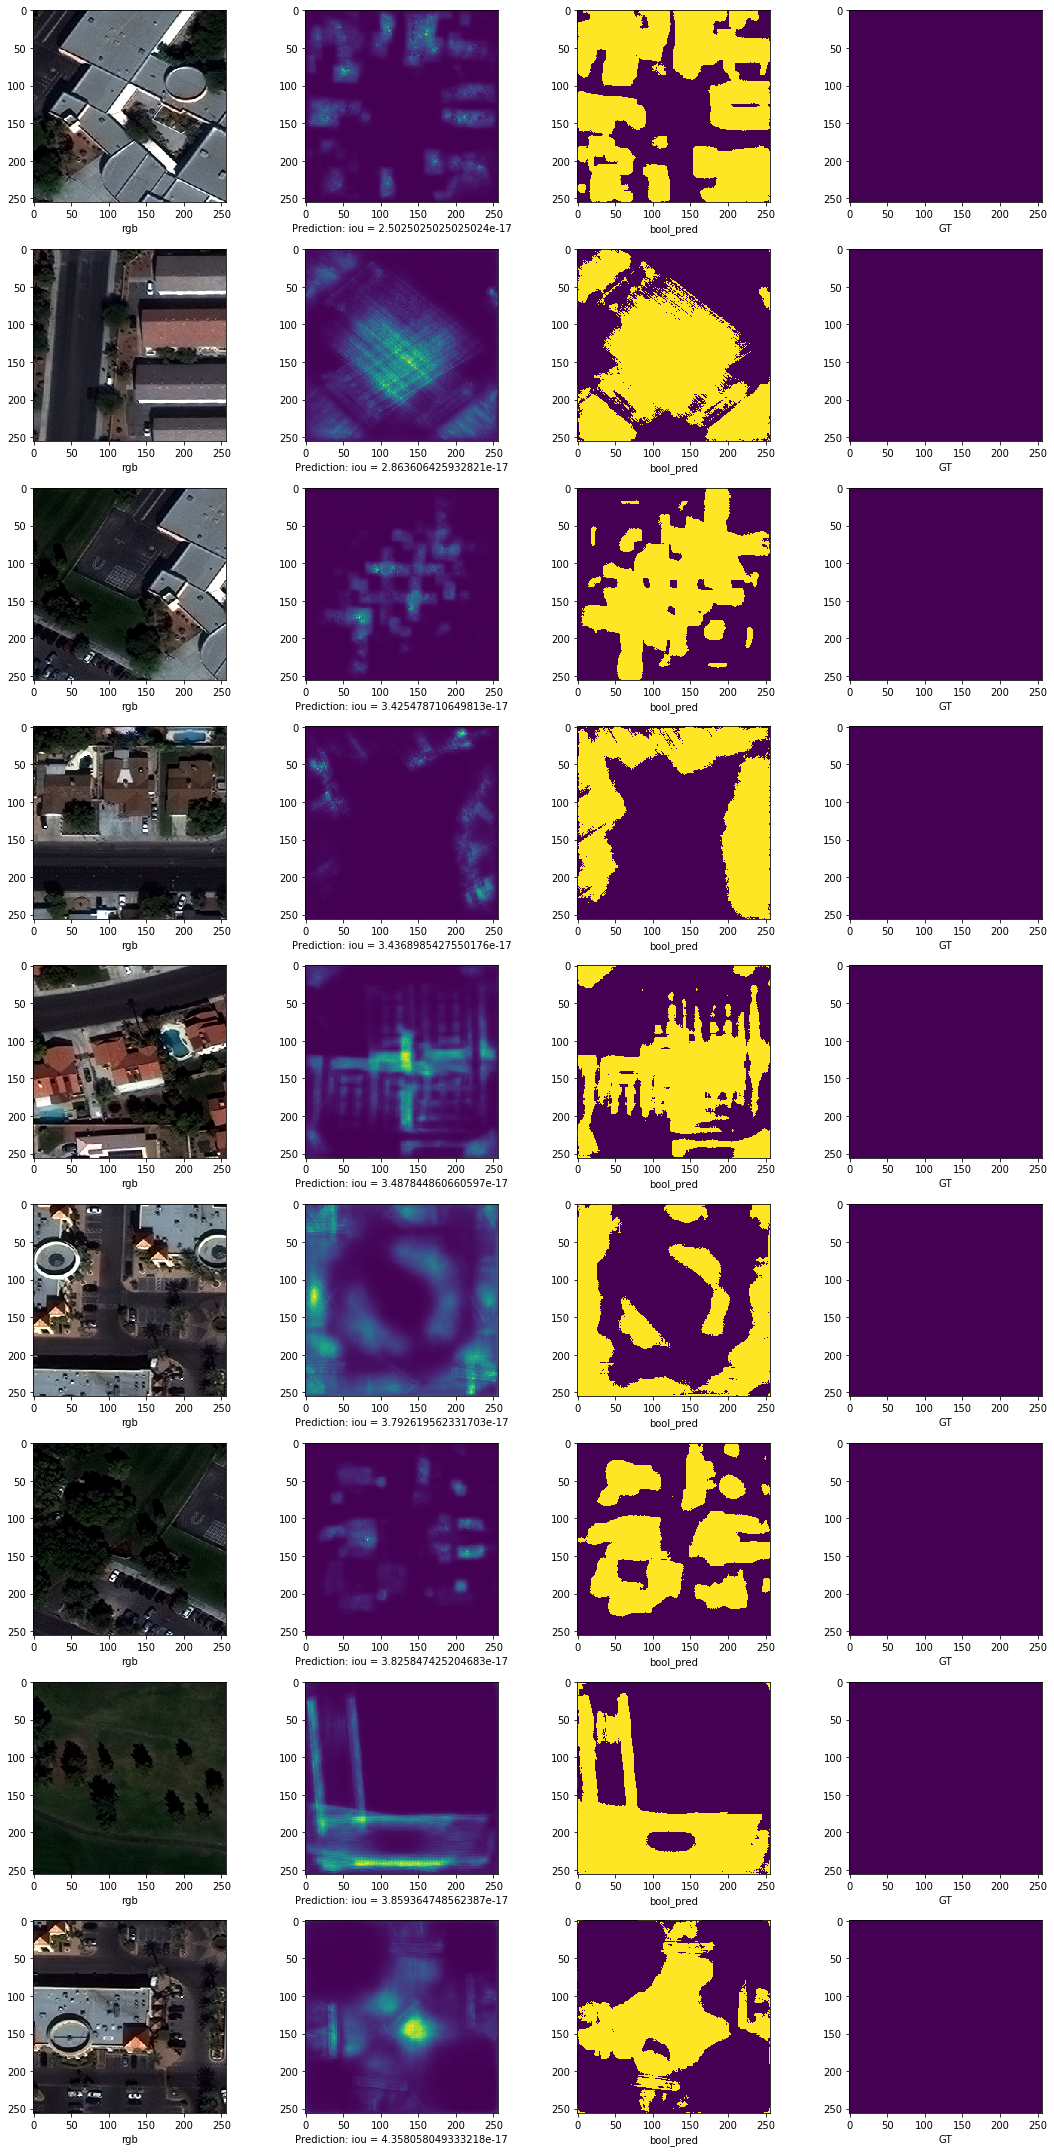

In [54]:
plot_worse(tta)

(9, 4)
[9, 9, 9, 9]


TypeError: Invalid dimensions for image data

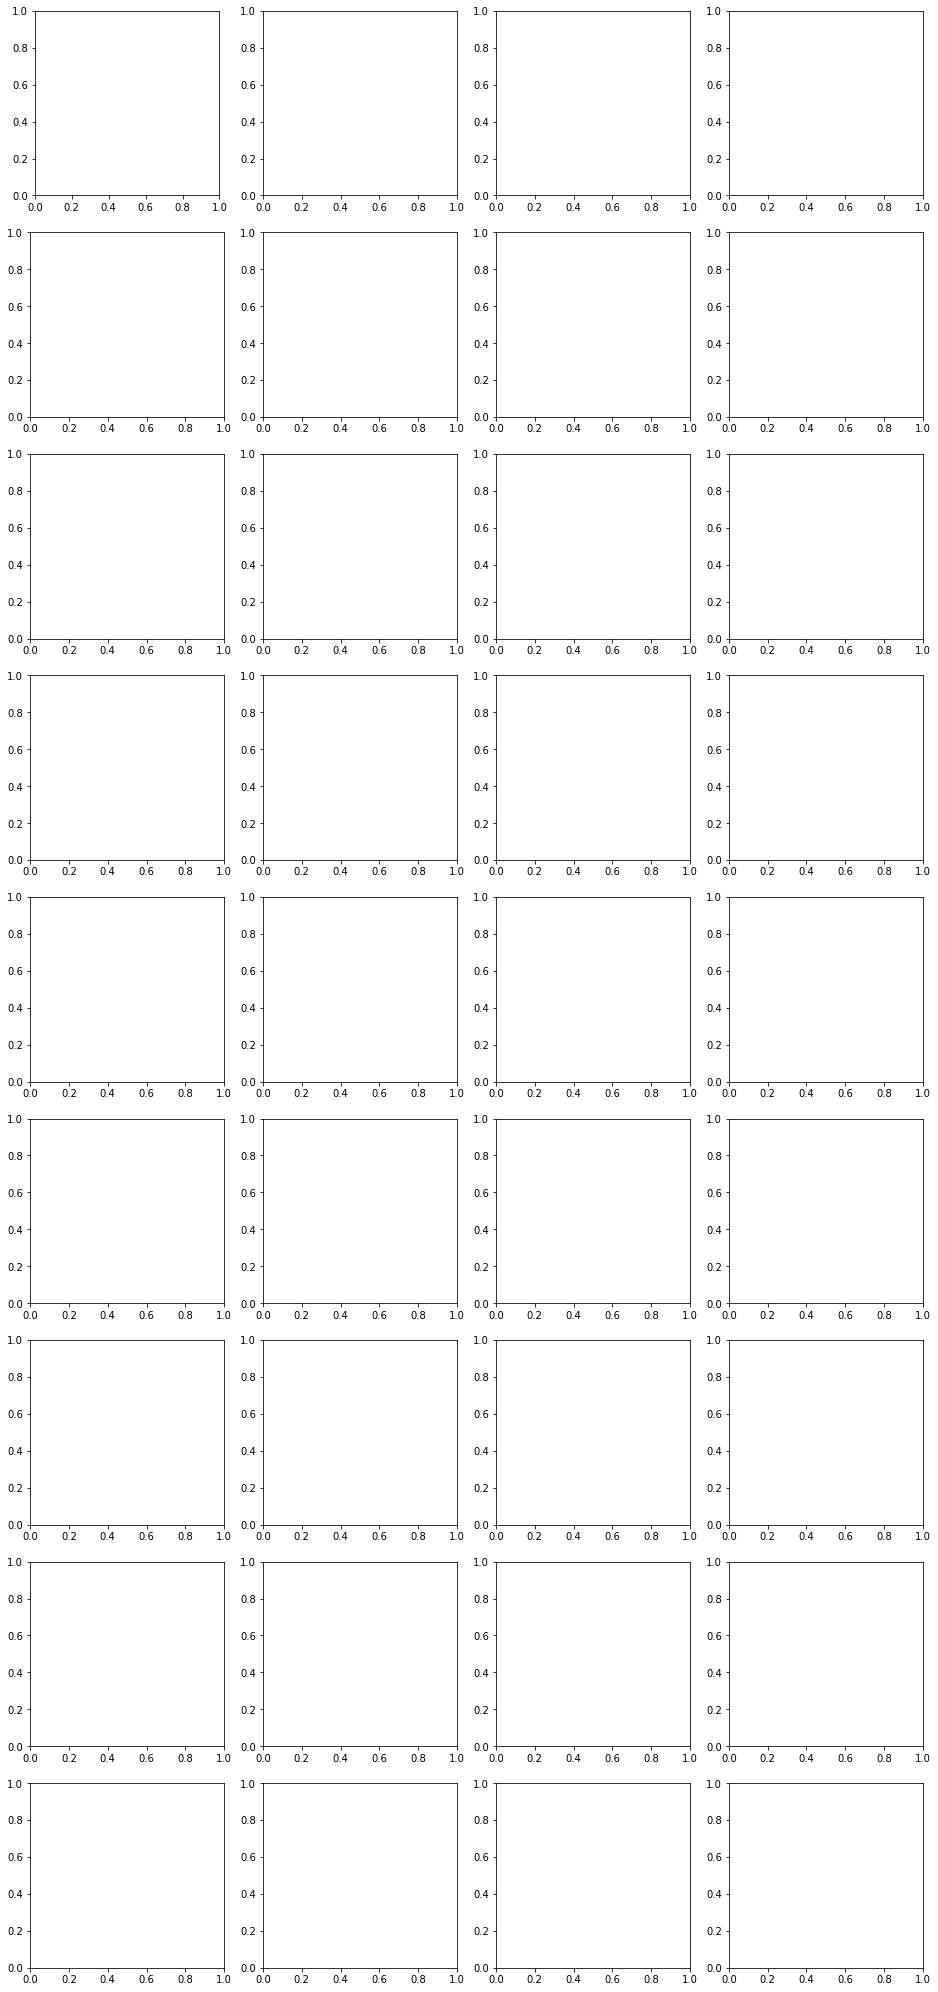

In [52]:
plot_worse_preds(tta_exp[:10], tta[1][:10], learn)